In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

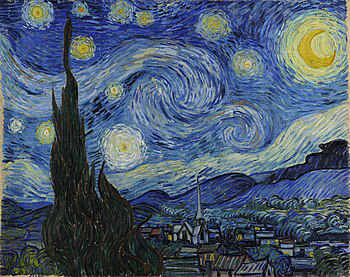

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.ref_image_name}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}_{evo.selection_method}.png")

def run_algorithm(settings):
    seed, ref_image_name, population_size, crossover_method, num_points, initialization, generation_budget, selection_method = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name=selection_method,
                    verbose=verbose_output,
                    ref_image_name=ref_image_name)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [5]:
# %%time
# data = run_algorithm((0, 100, "UNIFORM", 100, 'RANDOM', 500))

## Running a sweep of settings

In [6]:
population_size = 100
generation_budget = 500
ref_image_name = "starry_night"

In [7]:
%%time

data = []
for seed in range(1
):
    for population_size in (population_size,):
        for crossover_method in ("UNIFORM",):
            for initialization in ("RANDOM",):
                for selection_method in ("optimization",):
                    for num_points in (population_size,):
                        data.extend(run_algorithm((seed, ref_image_name, population_size, crossover_method, num_points, initialization, generation_budget, selection_method)))

Best current method: stochastic_universal_sampling, Diversity=3.963826478377037, Quality=0.5997234537003903, Combined Criterion=3.963826478377037
generation: 1 best fitness: 177857 avg. fitness: 205257.33
Best current method: roulette_wheel_selection, Diversity=3.9297728712894324, Quality=0.5980207798337475, Combined Criterion=2.26389682556159
generation: 2 best fitness: 169651 avg. fitness: 204476.57
Best current method: stochastic_universal_sampling, Diversity=3.925301183525201, Quality=0.5980207798337475, Combined Criterion=1.7071142477308985
generation: 3 best fitness: 169651 avg. fitness: 204487.97
Best current method: roulette_wheel_selection, Diversity=3.89318487050079, Quality=0.6019352087965166, Combined Criterion=1.424747624222585
generation: 4 best fitness: 169651 avg. fitness: 204619.71
Best current method: roulette_wheel_selection, Diversity=3.8520253032300236, Quality=0.6286915633262701, Combined Criterion=1.2733583113070208
generation: 5 best fitness: 169651 avg. fitness

## Evaluating the results

In [ ]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

In [ ]:
# your plotting code here...

## Displaying the best instances over time

In [ ]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, ref_image_name, population_size, crossover_method, num_points, initialization, generation_budget, selection_method = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{ref_image_name}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}_{selection_method}.png")) for i in selection]
    
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

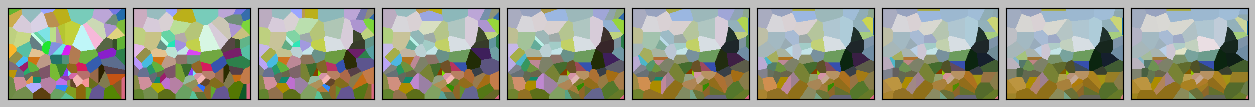

In [ ]:
show_progress_over_time((0, ref_image_name, population_size, 'UNIFORM', population_size, "RANDOM", generation_budget, "optimization"), grid=(1,10))

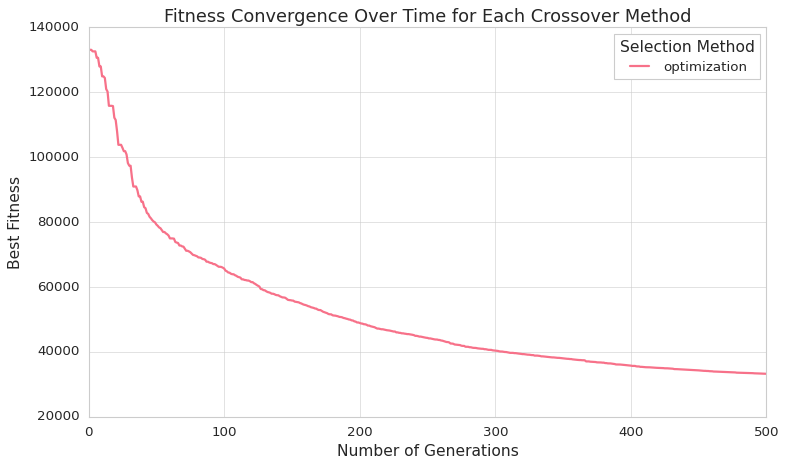

In [ ]:
df = pd.DataFrame(data)

df_stats = df.groupby(['num-generations', 'selection-method']).agg(
    mean_fitness=('best-fitness', 'mean'),
    std_fitness=('best-fitness', 'std')
).reset_index()

sns.set_style("whitegrid")
custom_palette = sns.color_palette("husl", 3)

plt.figure(figsize=(10, 6))

for method, color in zip(df_stats['selection-method'].unique(), custom_palette):
    method_data = df_stats[df_stats['selection-method'] == method]
    plt.plot(method_data['num-generations'], method_data['mean_fitness'], label=method, color=color, linewidth=2)
    plt.fill_between(
        method_data['num-generations'],
        method_data['mean_fitness'] - method_data['std_fitness'],
        method_data['mean_fitness'] + method_data['std_fitness'],
        color=color,
        alpha=0.3
    )

plt.title('Fitness Convergence Over Time for Each Crossover Method', fontsize=16)
plt.xlabel('Number of Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Selection Method', title_fontsize='14', fontsize='12', loc='best')
plt.tight_layout()
plt.show()
